# Day 4: Convergence orders of Langevin discretizations and Monte-Carlo error

In [1]:
# For today's exercises you will need to load the following packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

from miniMD import models
from miniMD import integrators
from miniMD import outputshedulers as outp

## Exercise 1
In today's first exercise we will take a closer look at the discretization error in the Leimkuhler Matthews and the Euler-Maruyama method when applied to the under overdamped Langevin equation

$$
\dot{q} = - \nabla U(q) + \sqrt{2 \beta^{-1}} \dot{W}.
$$

For this purpose we will consider the following simple cosine potential which is defined on the periodic domain $[0,2\pi)$:

$$
U(q) = \cos(q), q \in [0,2\pi),
$$

The class `CosineModel` in ./miniMD/models.py implements this potential. It also implements the function `apply_boundary_conditions(self, q)`, which resolves the periodic boundary conditions.

- Create an instance of `CosineModel` with default parameter values. Plot the potential function on the interval and the associated Gibbs density at unit temperature on the inveral $[0,2\pi)$. For the computation of the Gibbs density you can use the below code snippet: 


In [2]:
Tk_B = 1.0
model = models.CosineModel()
gibbs_not_normalized = lambda q: np.exp(-Tk_B*model.comp_potential(q))
Z,err =  scipy.integrate.quad(gibbs_not_normalized,0,2*np.pi)
gibbs = lambda q: gibbs_not_normalized(q)/Z

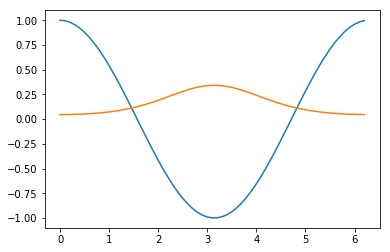

In [12]:
x = np.arange(0,6.28,.1)
fig,ax = plt.subplots()
ax.plot(x, model.comp_potential(x))
ax.plot(x,gibbs(x))
plt.show()

In the next step we are going to evaluate the convergence order for the Leimkuhler-Matthews method and the Euler-Maruyama method in the stepsize $h$ as $h\rightarrow 0$ of the error in ergodic avergages,

$$
\begin{aligned}
\mathcal{E}(\varphi,h) &:= \lim_{N\rightarrow \infty} \left | \frac{1}{N}\sum_{n=0}^{N-1} \varphi(q_n) - \int \varphi(q) \rho_{\beta}(q) d q \right |\\
&=\left | \int  \varphi(q) \rho_{\beta}(q) d q - \int   \varphi(q)\widehat{\rho}_{h,\beta}(q) d q \right |
\end{aligned}
$$

where 
$$\rho_{\beta}(q) = \frac{1}{Z} \exp(-\beta U(q)),$$
is the density of the associated Gibbs-measure, and $\widehat{\rho}_{h,\beta}(q)$ is the invariant measure of the discrete dynamics (see also slide 40 from of day 3 of the lectures for a definition of the ergodic error).

In what follows we investigate the  behaviour of $\mathcal{E}(\varphi,h)$ for the choices  $$\varphi(q) := {\bf 1}_{S_i}(q)= \begin{cases} 1 &if ~q \in S\\ 0 & if ~q \not\in S \end{cases}, $$ with  $S_i:=[\frac{i}{12} \pi,\frac{i+1}{12}\pi], ~ i=0,1,2,\dots,11.$.

- Compute (numerically) reference solutions `ref_solutions`, i.e., compute the values of the integrals 
$$
\int  {\bf 1}_{S_i}(q) \rho_{\beta}(q) d q
$$
Start with the below code snippet:

In [3]:
nbins = 12
q_bins = np.linspace(0.0,2.0*np.pi,nbins+1)
ref_solutions = np.zeros(nbins)

In order to reduce the number of time steps $N$ we need to compute to get a good estimate of
$$
\int  {\bf 1}_{S_i}(q) \widehat{\rho}_{h,\beta}(q) d q
$$
we use a few tricks to reduce the computaional load (Python is quite slow...). First, we will use 1000 replicas to compute the above estimates, and secondly we will initialise the system in equilirbium, i.e., we will sample the initial values of $q$ at the beginning of the simulation from the Gibbs measure $\rho_\beta(q)d q$:

In [13]:
# Generate 1000 random i.i.d. initial values sampled from the Gibbs measure
dim = 1000 
q0 = np.zeros(dim)
for i in range(dim):
    acc = False
    while (not acc):
        u = np.random.uniform(0,2*np.pi)
        v = np.random.uniform(0,1)
        if v < gibbs_not_normalized(u)/np.exp(Tk_B):
            q0[i] = u
            acc =True

Now we can compute estimates using either the Euler-Maruyama integrator or the Leimkuhler-Matthews method with different step sizes. We will use trajectories of length T=10000$ (physical time) to compute these estimates. Usually, finding the right range of stepsizes is quite tedious. Therefore, these are provided for you in the below code snippet as `h_vec`. Fill in the missing parts in the below code snippet. 

In [15]:
T=10000 # Physical time
n_stepsizes = 5 
h_vec = np.logspace(-.3,0.3, n_stepsizes)
'''
create an instance of the cosine model with dim=1000  
'''
model = models.CosineModel(dim=1000)
i=0
approx_solutions = np.zeros([n_stepsizes,nbins])
for h in h_vec:
    print(i)
    '''
    Initialize 
        - the integrator with stepsize h and the above specified model
        - an instance "op" of BufferedOutputsheduler with the appropiate number of time steps so
            that a trajectory of physical time T is generated
        - run the integrator with initial values q0 
        
    '''
    integrator = integrators.EulerMaruyamaBD(model, h=h, Tk_B = 1.0)
    op = outp.BufferedOutputsheduler(integrator, 
                                 Nsteps=int(T/integrator.h), 
                                 varname_list=['q'], 
                                 modprnt=1)
    integrator.run(initial_values={'q' : q0})
    approx_solutions[i,:] = np.histogram(op.traj_q,q_bins, density=True)[0] # Collect the histogram of the i-th simulation run
    i += 1


0
1
2
3
4


**Note**: If you are using your own implementation of the Leimkuhler-Matthews method, make sure that between the position update and the force computation, the periodic boundary conditions are resolved, i.e., insert the function apply_boundary_conditions with the appropiate arguments after the positon update.

- Compute the error for each observable. Choose one to create a plot "step size vs error" in a loglog plot. You may want to include the plot of a first and second order line for orientation, i.e., include plots showing "step size vs (step size)/2" and "step size vs (step size)^2/10" 

## Exercise 2 (Weak error vs. error in ergodic averages)

In yesterday's lecture you learned that while the error in ergodic averages of the  Leimkuhler-Matthews method converges as $O(h^2)$ as $h \rightarrow 0$, the weak error of the Leimkuhler-Matthews method converges as $O(h)$ as $h \rightarrow 0$. In what follows we will verify this property numerically. Recall that for time $T>0$, the weak error is defined as

$$
\mathcal{E}(\varphi,h,T) = \left |\mathbb{E}(\varphi(q_{Nh}) - \mathbb{E}(\varphi(q(T)))\right |, Nh = T,
$$

where in the case of the exact solution of the SDE, $q(T)$ the expectation is taken with respect to the Brownian motion, and in the case of the numerical approximation, $q_{Nh}$ the expectation is taken with respect to the random increment in each timestep. 

- Leimkuhler-Matthews Method, (weak order 1, ergodic error order 2)
- Euler-Maruyama Method, (weak order 1, ergodic error order 1) 

We use a similar setup as the one which we used in exercise 1, i.e., we use again the potential function

$$
U(q) = \cos(q), q \in [0,2\pi),
$$

and evaluate the error for the collection of observables 
$$\varphi(q) := {\bf 1}_{S_i}(q)= \begin{cases} 1 &if ~q \in S\\ 0 & if ~q \not\in S \end{cases}, $$ with  $S_i:=[\frac{i}{12} \pi,\frac{i+1}{12}\pi], ~ i=0,1,2,\dots,11.$

**However,** unlike in the first exercise, we will initialize the particles outside of equilibrium, and measure the weak error at finite times $T=1$, and $T=4$ (physical time) using a reference solution, which was computed using a high order scheme with very small step size.

- create an instance of the class `CosineModel` with the dimension parameter `dim` set to $10^6$.
- using the LeimkuhlerMatthews method sample trajectories of length $T=1$ and $T=4$ (physical time) using stepsizes of length $h = 1,1/2,1/3,1/4,1/5$. As an outputsheduler you should create an instance `op` of the class `HistogramOutputsheduler`, which at each time step computes a historgram of the monitored variables. After each simulation run you can access the trajectory of histograms as `op.traj_bins_q`. For each simulation run save the histogram corresponding to the last time step, i.e., `op.traj_bins_q[-1,:]` in an array called  `approx_solutions`. You can use the code snippet below to initalise your outputsheduler. Make sure that the value of q_bins is set as above in exercise 1. 




In [ ]:
op = outp.HistogramOutputsheduler(integrator, 
                                 Nsteps, 
                                 varname_list=['q'],
                                 bins_list = [q_bins],
                                 modprnt=1)

**Note!** The histogram  `op.traj_bins_q` is not normalized! Use the command sequence 

    pdf_sum = np.sum(op.traj_bins_q[-1,:])
    op.traj_bins_q[-1,:]/=pdf_sum 
   
to normalize the histogram after each simulation run

Using the command 
`ref_solutions = np.load('reference_t={}d.npy'.format(int(T)),allow_pickle=False)`
you can load a reference solution computed with a high order scheme (Stochastic Heun) using a a small stepsize (h=0.01). Use the last entry of the trajectory, i.e., `ref_solutions[-1,:]`, which corresponds to the histogram computed at time $T$. Using this reference solution compute the error sum
$$
\sum_{i=1}^{12}\mathcal{E}({\bf 1}_{S_i},h,T)
$$
for $T=1$ and $T=4$. Create a loglog plot 'h vs error sum' for each value of $T$. Again include plots for the first and second order line for orientation. Repeat your numerical experiments using the Euler-Maruyama schem  
